# Nearest neighbor analysis with large datasets

While Shapely's `nearest_points` -function provides a nice and easy way of conducting the nearest neighbor analysis, it can be quite slow. Using it also requires taking the `unary union` of the point dataset where all the Points are merged into a single layer. This can be a really memory hungry and slow operation, that can cause problems with large point datasets.  

Luckily, there is a much faster and memory efficient alternatives for conducting nearest neighbor analysis, based on a function called [BallTree](https://en.wikipedia.org/wiki/Ball_tree) from a [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) library. The Balltree algorithm has some nice features, such as the ability to calculate the distance between neighbors with various different distance metrics. Most importantly the function allows to calculate `euclidian` distance between neighbors (good if your data is in metric crs), as well as `haversine` distance which allows to determine [Great Circle distances](https://en.wikipedia.org/wiki/Great-circle_distance) between locations (good if your data is in lat/lon format). *Note: There is also an algorithm called [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) in scikit-learn, that is also highly efficient but less flexible in terms of supported distance metrics.* 

## Motivation

In this tutorial, we go through a very practical example that relates to our daily commute: Where is the closest public transport stop from my place of living? Hence, our aim is to search for each building in Helsinki Region (around 159 000 buildings) the closest public transport stop (~ 8400 stops). The building points have been fetched from OpenStreetMap using a library called [OSMnx](https://github.com/gboeing/osmnx) (we will learn more about this library later), and the public transport stops have been fetched from open [GTFS dataset for Helsinki Region](https://transitfeeds.com/p/helsinki-regional-transport/735) that contains information about public transport stops, schedules etc. 

## Efficient nearest neighbor search with Geopandas and scikit-learn

The following examples show how to conduct nearest neighbor analysis efficiently with large datasets. We will first define the functions and see how to use them, and then we go through the code to understand what happened.

- Let's first read the datasets into Geopandas. In case of reading the building data, we will here learn a trick how to read the data directly from a ZipFile. It is very practical to know how to do this, as compressing large datasets is a very common procedure.

In [1]:
import geopandas as gpd
from zipfile import ZipFile
import io

def read_gdf_from_zip(zip_fp):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage) 
    inside the ZipFile.
    """
    with ZipFile(zip_fp) as z:
        # Lists all files inside the ZipFile, here assumes that there is only a single file inside
        layer = z.namelist()[0]
        data = gpd.read_file(io.BytesIO(z.read(layer)))
    return data

# Filepaths
stops = gpd.read_file('data/pt_stops_helsinki.gpkg')
buildings = read_gdf_from_zip('data/building_points_helsinki.zip')

- Let's see how our datasets look like:

In [2]:
print(buildings.head())
print('----------')
print(stops.head())

             name                   geometry
0            None  POINT (24.85584 60.20727)
1     Uimastadion  POINT (24.93045 60.18882)
2            None  POINT (24.95113 60.16994)
3  Hartwall Arena  POINT (24.92918 60.20570)
4           Talli  POINT (24.92607 60.21346)
----------
     stop_name   stop_lat   stop_lon  stop_id                   geometry
0  Ritarihuone  60.169460  24.956670  1010102  POINT (24.95667 60.16946)
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (24.95657 60.17127)
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (24.95672 60.17029)
3    Vironkatu  60.172580  24.956554  1010105  POINT (24.95655 60.17258)
4    Vironkatu  60.172990  24.956380  1010106  POINT (24.95638 60.17299)


Okay, so both of our datasets consisting points, and based on the coordinates, they seem to be in WGS84 projection.

- Let's also make maps out of them to get a better understanding of the data

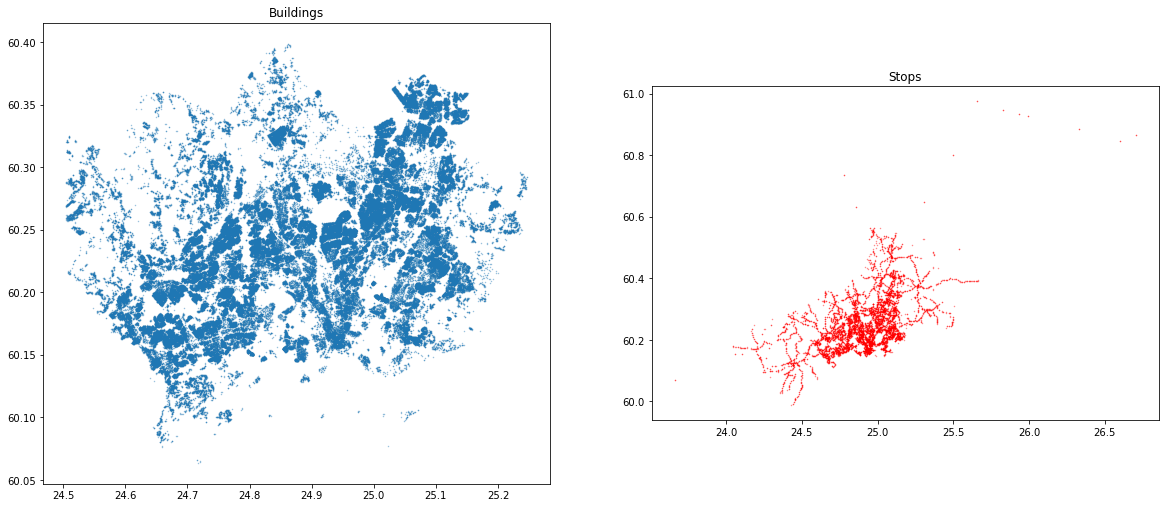

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot buildings
buildings.plot(ax=axes[0],markersize=0.2, alpha=0.5)
axes[0].set_title('Buildings')

# Plot stops
stops.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
axes[1].set_title('Stops');

As we can see, we have a very densely distributed Point dataset that shows the location of the buildings (their centroid) in Helsinki Region. On the right, we have public transport stops that seem to cover a bit broader geographical extent with a few train stops reaching further North. Most importantly, we can see from the coordinates and the map that both of the layers share the same coordinate reference system, and they are approximately from the same geographical region. Hence, we are ready to find closest public transport stop (on the right) for each building on the left map.     

- Let's first prepare a couple of functions that does the work

In [4]:
from sklearn.neighbors import BallTree
import numpy as np

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

Okay, now we have our functions defined. So let's use them and find the nearest neighbors!

In [5]:
# Find closest public transport stop for each building and get also the distance based on haversine distance 
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric 
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(buildings, stops, return_dist=True)

# And the result looks like ..
closest_stops

,stop_name,stop_lat,stop_lon,stop_id,geometry,distance
0,Muusantori,60.207490,24.857450,1304138,POINT (24.85745 60.20749),180.521584
1,Eläintarha,60.192490,24.930840,1171120,POINT (24.93084 60.19249),372.665221
2,Senaatintori,60.169010,24.950460,1020450,POINT (24.95046 60.16901),119.425777
3,Veturitie,60.206610,24.929680,1174112,POINT (24.92968 60.20661),106.762619
4,Autokuljetuskeskus 1,60.218810,24.923110,1286161,POINT (24.92311 60.21881),631.794206
...,...,...,...,...,...,...
158726,Bredantie,60.212770,24.723210,3170222,POINT (24.72321 60.21277),200.454057
158727,Kasavuori,60.211112,24.699637,3170256,POINT (24.69964 60.21111),262.973726
158728,Kandidaatintie,60.218180,24.736987,3170245,POINT (24.73699 60.21818),175.043184
158729,Uimahalli,60.215660,24.712090,3170213,POINT (24.71209 60.21566),139.212653


Great, that didn't take too long! Especially considering that we had quite a few points in our datasets (8400\*159000=1.33 billion connections). As a result, we have a new GeoDataFrame that reminds a lot the original `stops` dataset. However, as we can see there are much more rows than in the original dataset, and in fact, each row in this dataset corresponds to a single building in the `buildings` dataset. Hence, we should have exactly the same number of closest_stops as there are buildings. Let's confirm this: 

In [6]:
# Now we should have exactly the same number of closest_stops as we have buildings
print(f"{len(closest_stops)} == {len(buildings)}")

158731 == 158731


Indeed, that seems to be the case. Hence, it is easy to combine these two datasets together. Before continuing our analysis, let's take a bit deeper look, what we actually did with the functions above.  

### What did we just do? Explanation.

To get a bit more understanding of what just happened, let's go through the essential parts of the two functions we defined earlier, i.e. `nearest_neighbor()` and `get_closest()`.

The purpose of `nearest_neighbor()` function is to handle and transform the data from GeoDataFrame into `numpy arrays` (=super-fast data structure) in a format how `BallTree` function wants them. This includes converting the lat/lon coordinates into radians (and back), so that we get the distances between the neighboring points in a correct format: scikit-learn's [haversine distance metric](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) wants inputs as radians and also outputs the data as radians. To convert a lat/lon coordinate to radian, we use formula: `Radian = Degree * PI / 180`. By doing this, we are able to get the output distance information in meters (even if our coordinates are in decimal degrees). 

The `get_closest()` function does the actual nearest neighbor search using [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) function. We initialize the `BallTree` object with the coordinate information from the **right_gdf** (i.e. the point dataset that contains all the nearest neighbor candidates), and we specify the distance metric to be `haversine` so that we get the Great Circle Distances. The `leaf_size` parameter adjusts the tradeoff between the cost of BallTree node traversal and the cost of a brute-force distance estimate. Changing leaf_size will not affect the results of a query, but can significantly impact the speed of a query and the memory required to store the constructed tree. We determine the leaf_size as 15 which has been found to be a good compromise when [benchmarked](https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/). After we have built (initialized) the ball-tree, we run the nearest neighbor query with `tree.query(src_points, k=k_neighbors)`, where the src_points are the building-coordinates (as radians) and the `k` -parameter is the number of neighbors we want to calculate (1 in our case as we are only interested in the closest neighbor). Finally, we just re-arrange the data back into a format in which the closest point indices and distances are in separate numpy arrays. 

**Note:** The functions here assume that your input points are in WGS84 projection. If you pass the points in some other projection, it is highly likely that the distances between nearest neighbors are incorrect. Determining which is the nearest neighbor should not be affected, though.  

### Combining the neighboring datasets 

Okay, now as we have found closest stop for each building in the region, we can easily merge the information about closest stops back to the building layer. The order of the `closest_stops` matches exactly the order in `buildings`, so we can easily merge the datasets based on index. 

In [7]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={'geometry': 'closest_stop_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
buildings = buildings.join(closest_stops)

# Let's see what we have
buildings.head()

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance
0,None,POINT (24.85584 60.20727),Muusantori,60.20749,24.85745,1304138,POINT (24.85745 60.20749),180.521584
1,Uimastadion,POINT (24.93045 60.18882),Eläintarha,60.19249,24.93084,1171120,POINT (24.93084 60.19249),372.665221
2,None,POINT (24.95113 60.16994),Senaatintori,60.16901,24.95046,1020450,POINT (24.95046 60.16901),119.425777
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.92968,1174112,POINT (24.92968 60.20661),106.762619
4,Talli,POINT (24.92607 60.21346),Autokuljetuskeskus 1,60.21881,24.92311,1286161,POINT (24.92311 60.21881),631.794206


Excellent! Now we have useful information for each building about the closest stop including the `distance` (in meters) and also e.g. the name of the stop in `stop_name` column. 

- Now it is easy to do some descriptive analysis based on this dataset, that gives information about levels of access to public transport in the region: 

In [8]:
buildings['distance'].describe()

count    158731.000000
mean        299.288617
std         372.787458
min           1.358302
25%         133.853322
50%         218.742047
75%         341.648944
max        7153.941499
Name: distance, dtype: float64

Okay, as we can see the average distance to public transport in the region is around 300 meters. More than 75 % of the buildings seem to be within within 5 minute walking time (~370 meters with walking speed of 4.5 kmph) which indicates generally a good situation in terms of accessibility levels in the region overall. There seem to be some really remote buildings in the data as well, as the longest distance to closest public transport stop is more than 7 kilometers.

- Let's make a map out of the distance information to see if there are some spatial patterns in the data in terms of accessibility levels:

<AxesSubplot:>

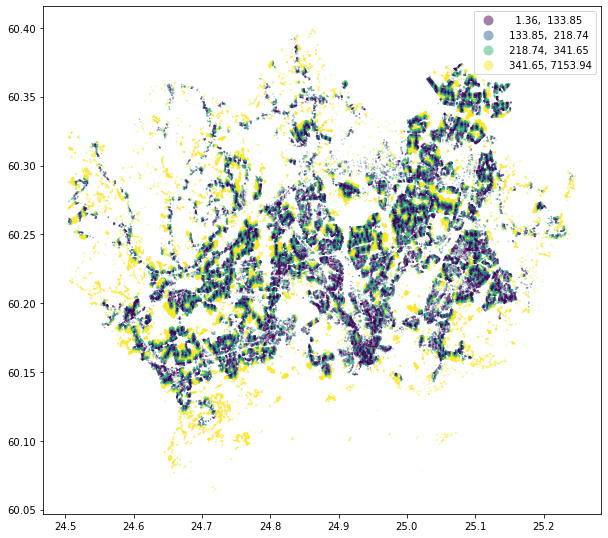

In [9]:
buildings.plot(column='distance', markersize=0.2, alpha=0.5, figsize=(10,10), scheme='quantiles', k=4, 
               legend=True)

Okay, as we can see, there are some clear spatial patterns in the levels of access to public transport. The buildings with the shortest distances (i.e. best accessibility) are located in the densely populated areas, whereas the buildings locating in the periferial areas (such as islands on the South, and nature areas in the North-West) tend to have longer distance to public transport. 

### Are the results correct? Validation

As a final step, it's good to ensure that our functions are working as they should. This can be done easily by examining the data visually.

- Let's first create LineStrings between the building and closest stop points:

In [10]:
from shapely.geometry import LineString

# Create a link (LineString) between building and stop points
buildings['link'] = buildings.apply(lambda row: LineString([row['geometry'], row['closest_stop_geom']]), axis=1)

# Set link as the active geometry
building_links = buildings.copy()
building_links = building_links.set_geometry('link')


C:\Users\mando\.conda\envs\python-gis\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


- Let's now visualize the building points, stops and the links, and zoom to certain area so that we can investigate the results, and confirm that everything looks correct.

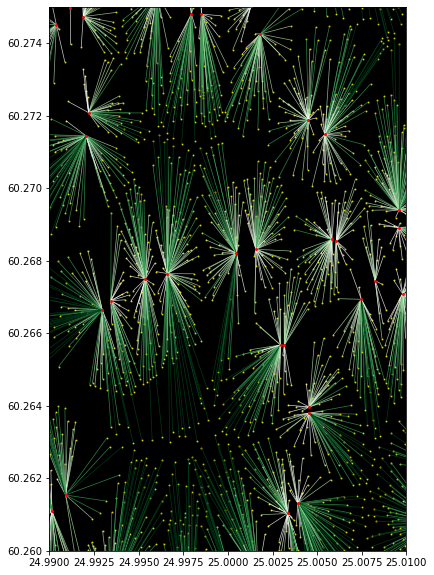

In [11]:
# Plot the connecting links between buildings and stops and color them based on distance
ax = building_links.plot(column='distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = buildings.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = stops.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
ax.set_xlim([24.99, 25.01])
ax.set_ylim([60.26, 60.275])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

Voilá, these weird star looking shapes are formed around public transport stops (red) where each link is associated buildings (yellow points) that are closest to the given stop. The color intensity varies according the distance between the stops and buildings. Based on this figure we can conclude that our nearest neighbor search was succesfull and worked as planned.